In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import os
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance,KElbowVisualizer

In [2]:
%matplotlib inline

In [3]:
path = 'E:\\Data_Science\\OpenClassRoom\\Projet 5\\archive\\'
x = input('Labtop ? [y/n]')
if x == 'y':
    path = r'C:\Users\Nico Janko\Documents\Data_Science\OpenClassRoom\Projet 5\archive'

Labtop ? [y/n] y


In [4]:

cust_df=pd.read_csv(path + '\olist_customers_dataset.csv')
geo_df=pd.read_csv(path +'\olist_geolocation_dataset.csv')
ord_it_df=pd.read_csv(path + '\olist_order_items_dataset.csv')
ord_pay_df=pd.read_csv(path + '\olist_order_payments_dataset.csv')
ord_rev_df=pd.read_csv(path + '\olist_order_reviews_dataset.csv')
ord_df=pd.read_csv(path + '\olist_orders_dataset.csv')
prod_df=pd.read_csv(path + '\olist_products_dataset.csv')
sell_df=pd.read_csv(path + '\olist_sellers_dataset.csv')

In [5]:
dfs = {0:cust_df,1:geo_df,2:ord_it_df,3:ord_pay_df,4:ord_rev_df,5:ord_df,6:prod_df,7:sell_df}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-n

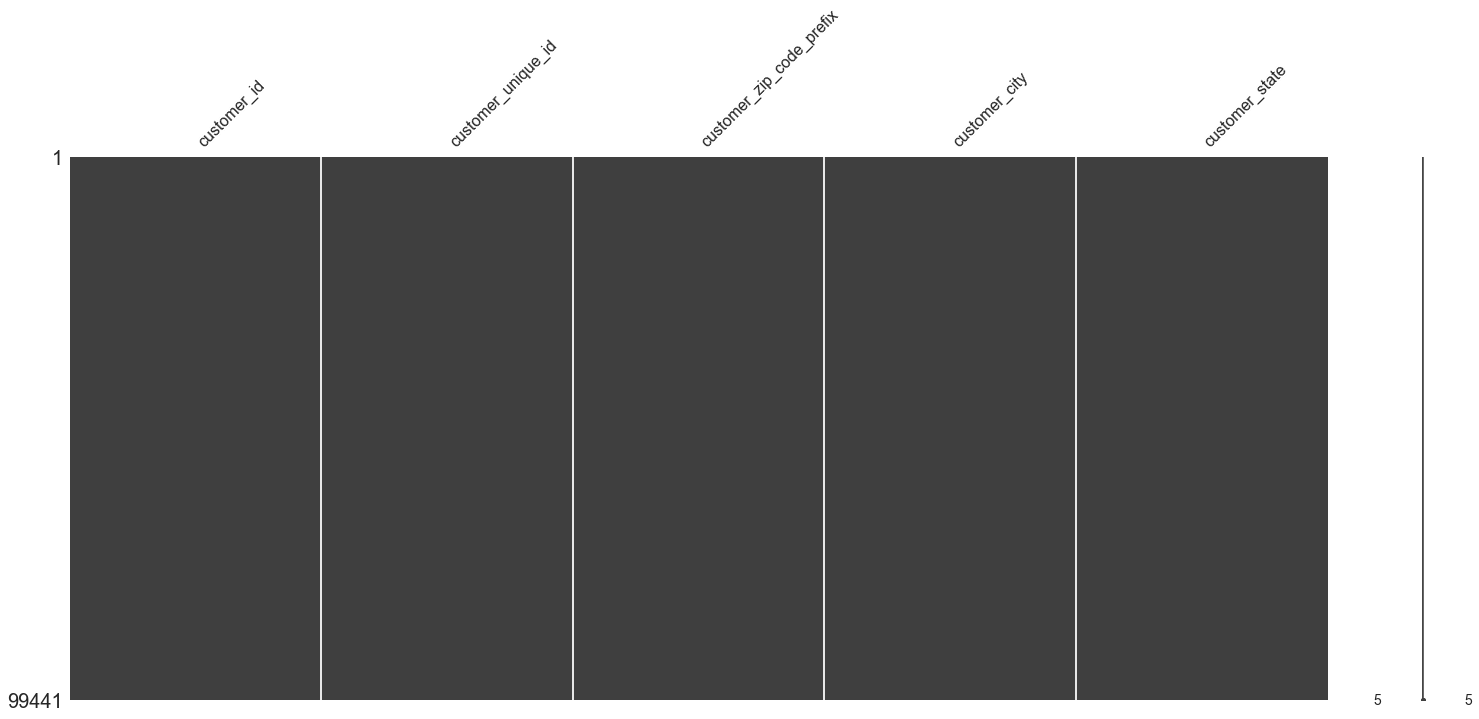

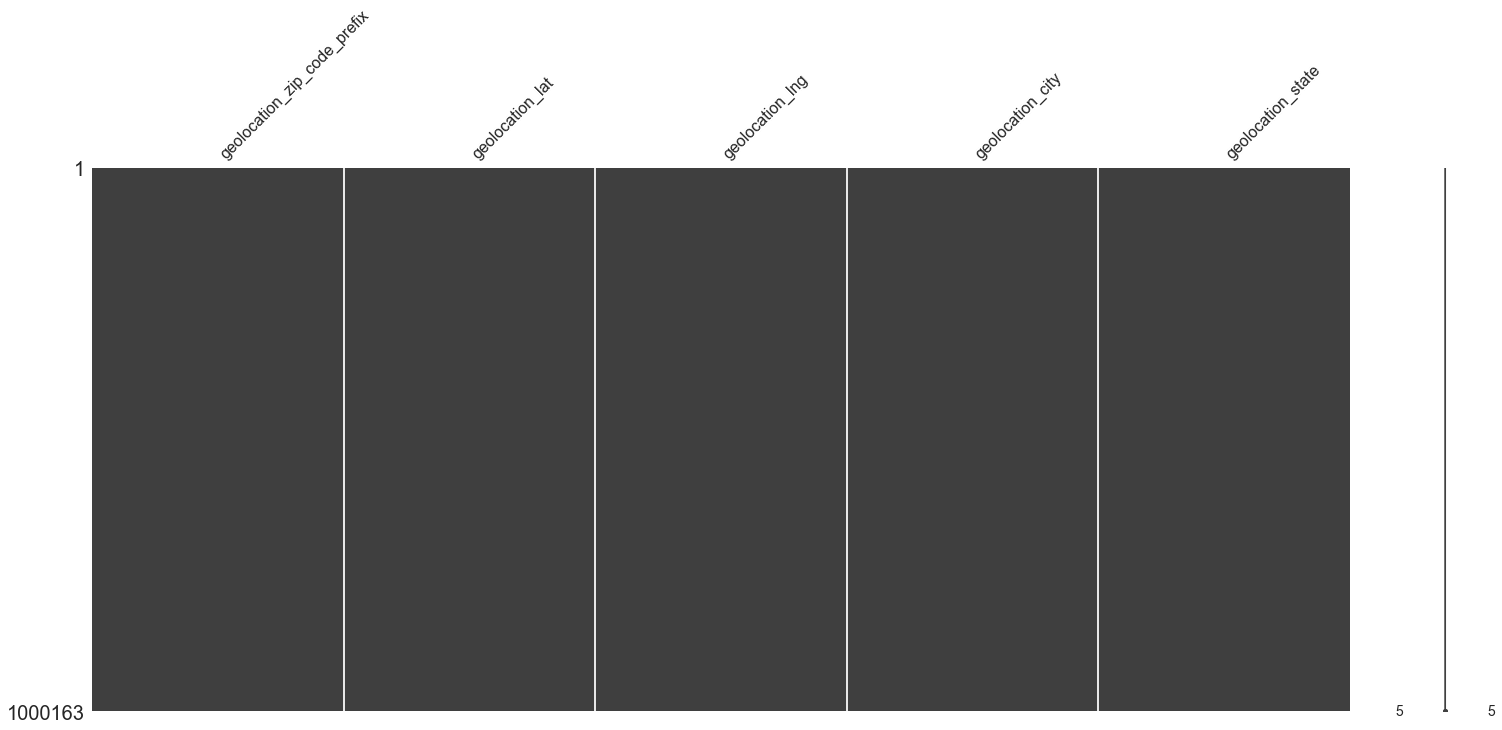

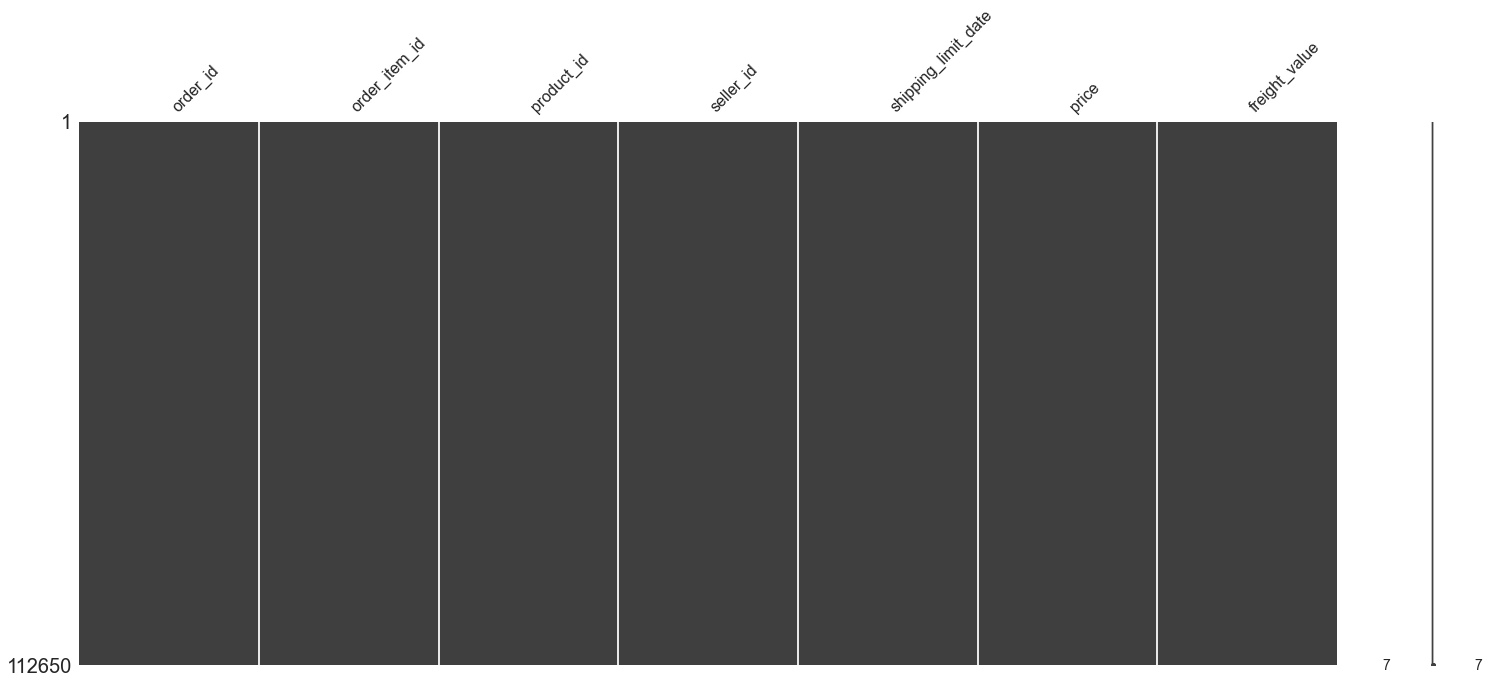

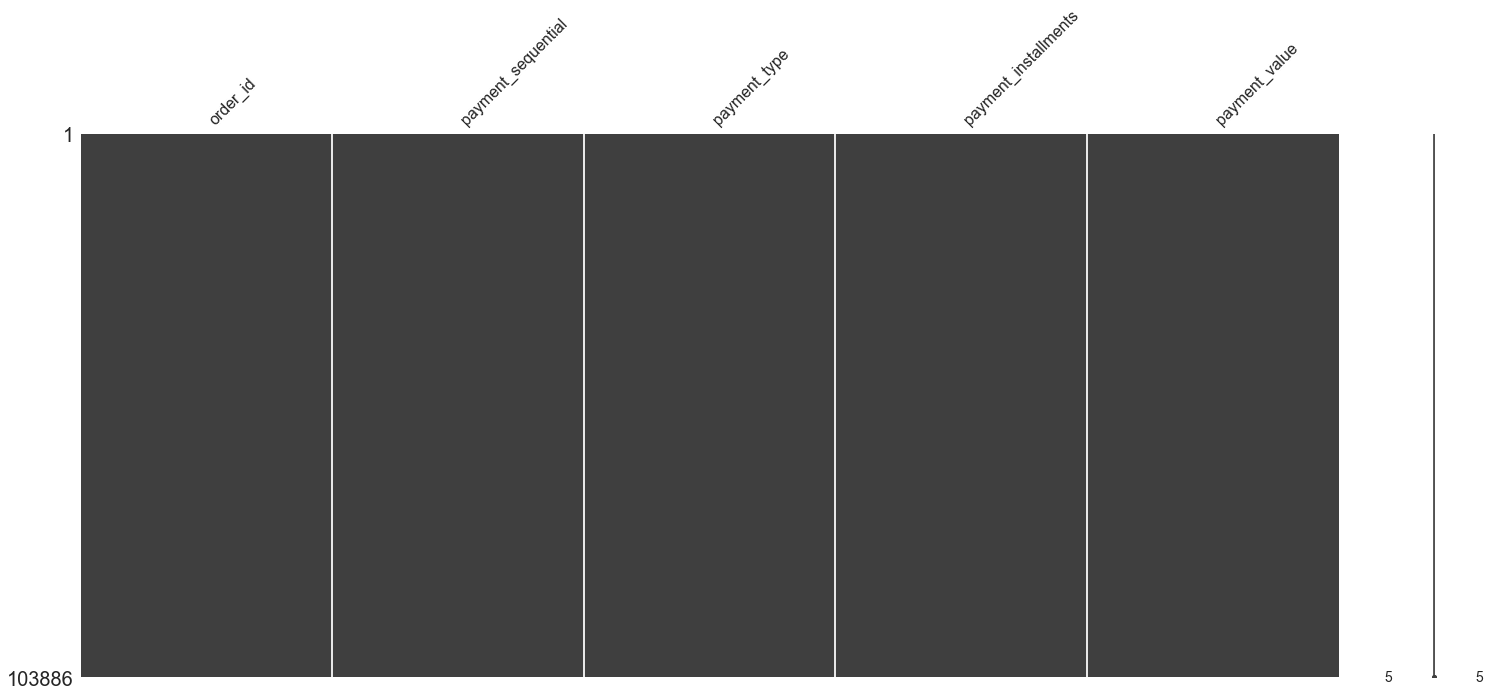

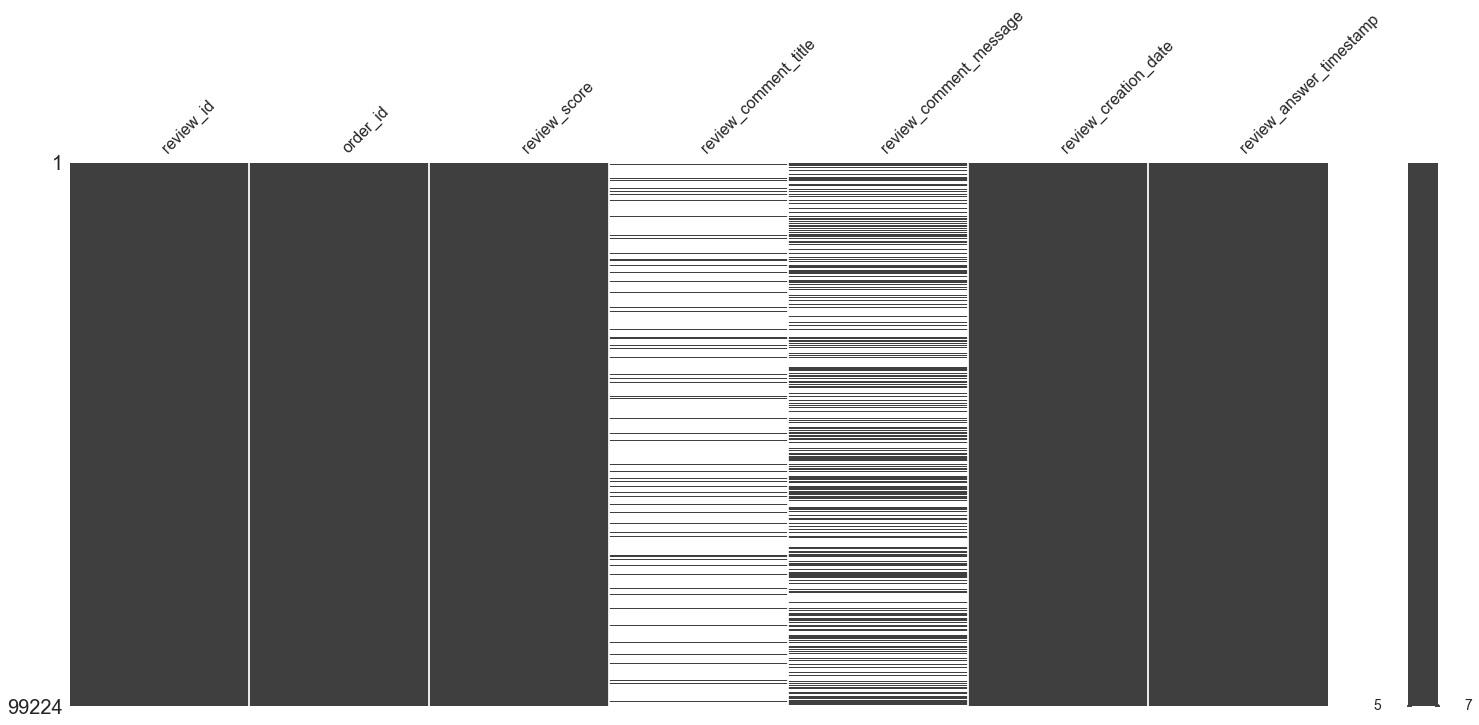

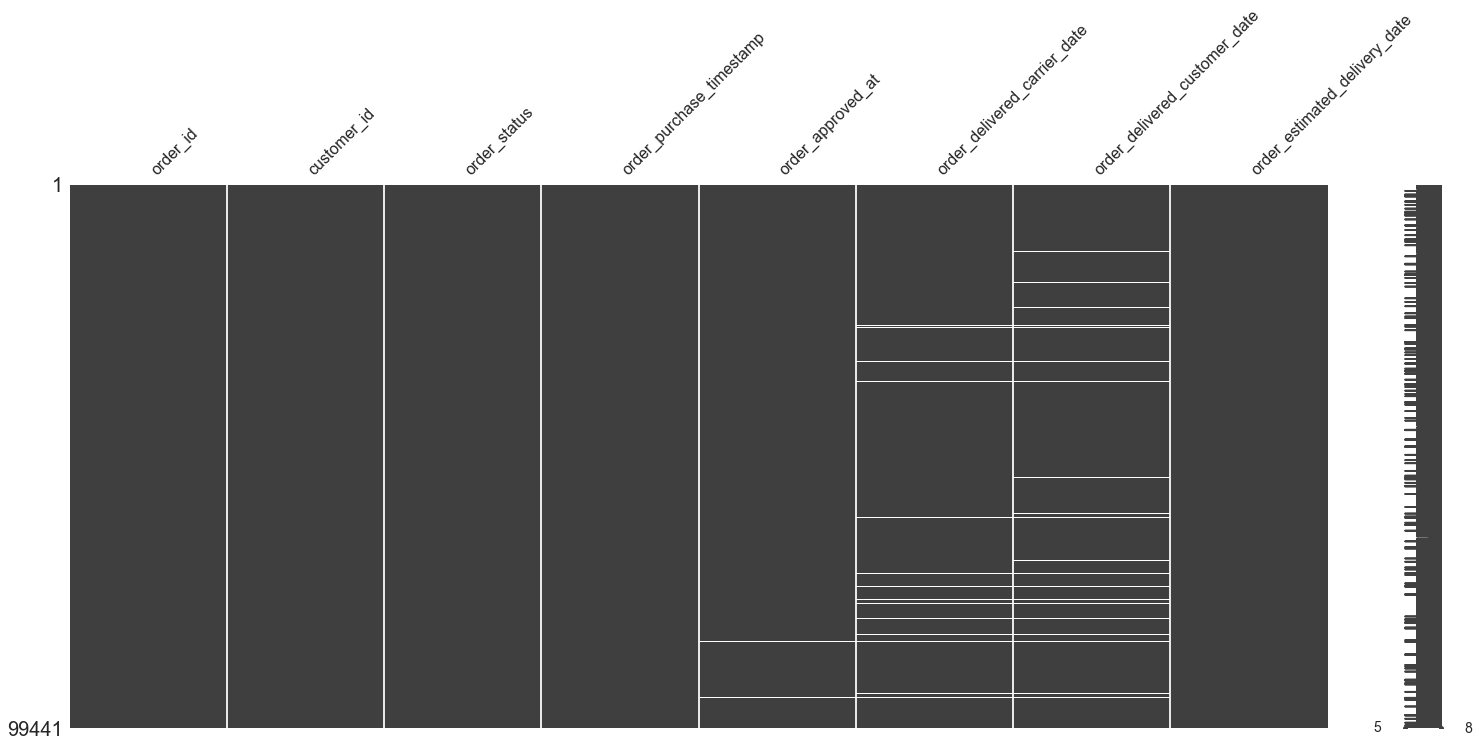

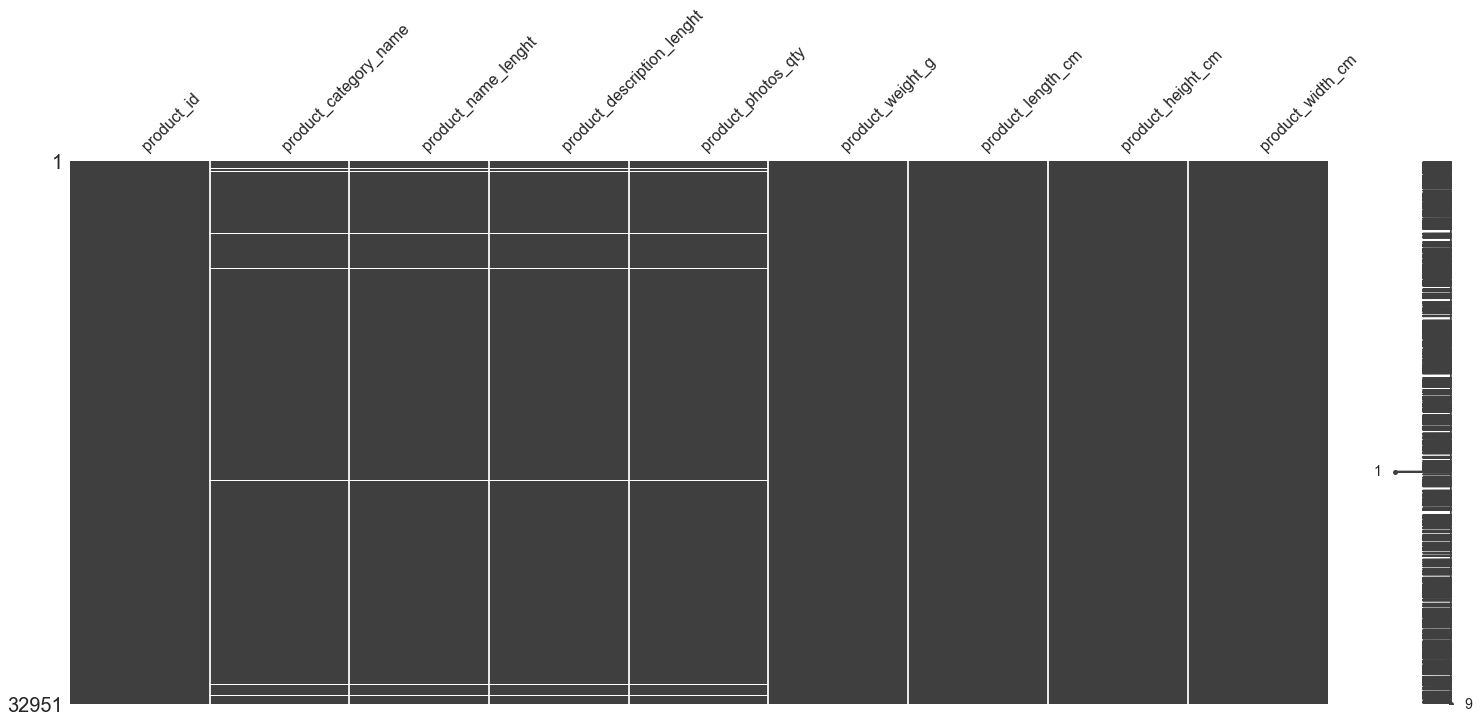

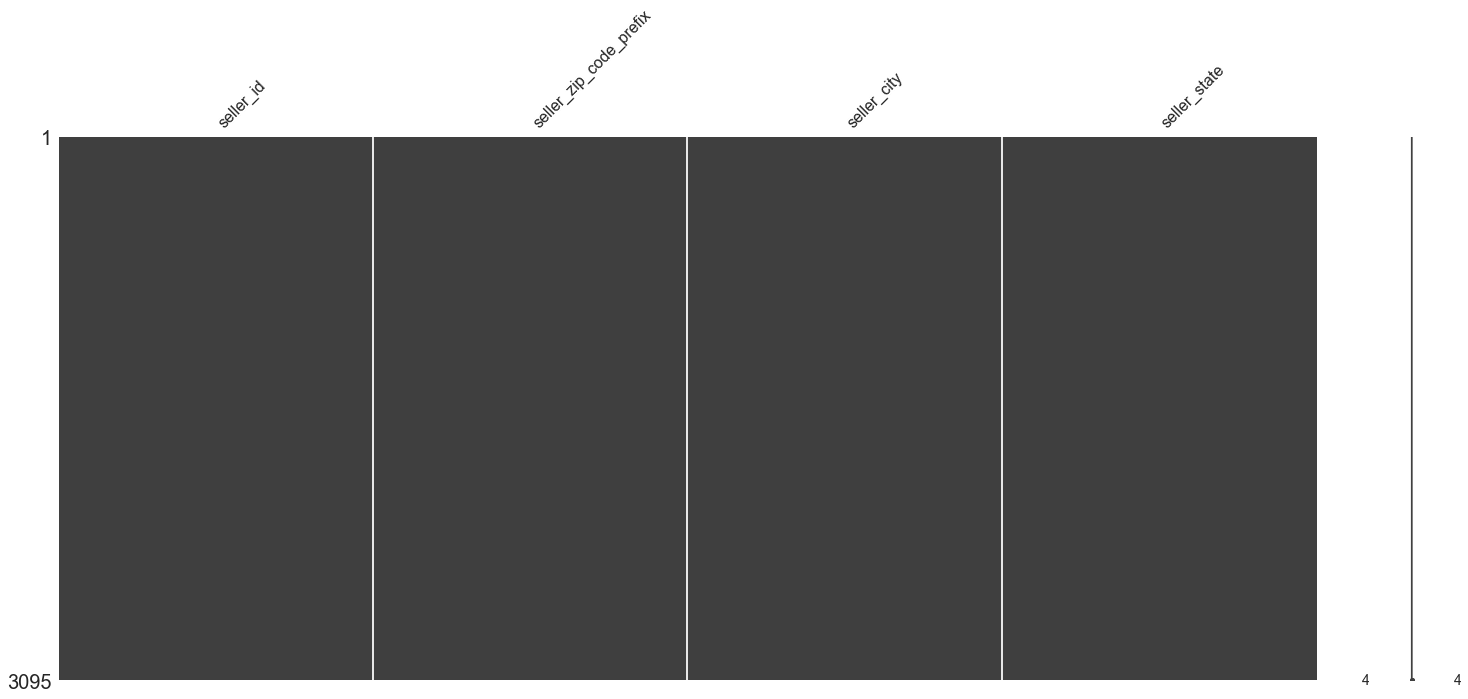

In [6]:
for i in dfs:
    print(dfs[i].info())
    msno.matrix(dfs[i])
    plt.savefig(f'msno_df{i}.png', bbox_inches = 'tight')

In [7]:
#get the customers that ordered more than once
multi_cust_df = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 1]

#get their customer_id
multi_custom = multi_cust_df[['customer_id','customer_unique_id']]
multi_id = multi_custom['customer_id']
multi_uni_id = multi_custom['customer_unique_id']
#get their order_id
multi_order_df = dfs[5][dfs[5]['customer_id'].isin(multi_id)]
multi_order_id = multi_order_df['order_id']

multi_pay_df = dfs[3][dfs[3]['order_id'].isin(multi_order_id)]
#get their review score
multi_rev_df = dfs[4][dfs[4]['order_id'].isin(multi_order_id)]

#get the category of each order
multi_prod_df =  dfs[2][dfs[2]['order_id'].isin(multi_order_id)]
multi_prod_id = multi_prod_df['product_id']
multi_cat_df = dfs[6][dfs[6]['product_id'].isin(multi_prod_id)].set_index('product_id')

cat_ser = multi_cat_df['product_category_name']
multi_prod_df = multi_prod_df.join(cat_ser, on = 'product_id')
multi_prod_df = multi_prod_df.dropna(subset = 'product_category_name') #74 product don't have a category name


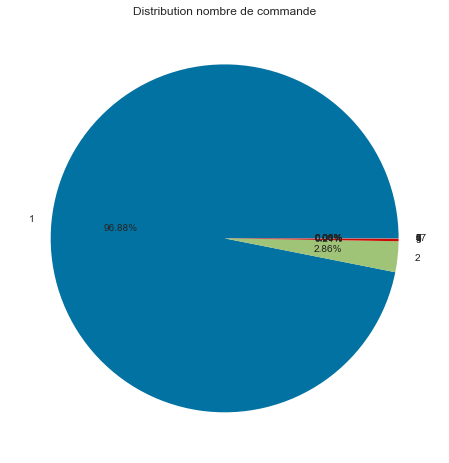

In [8]:
temp = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 0]
temp = temp[['customer_id','customer_unique_id']]
temp2 = dfs[5][dfs[5]['customer_id'].isin(temp['customer_id'])]
temp = temp.set_index('customer_id')
temp = temp.join(temp2[['customer_id','order_id']].set_index('customer_id'))
graph = pd.DataFrame()
graph['n_order'] = temp.groupby('customer_unique_id').order_id.count()

fig,ax = plt.subplots(figsize = (8,8))
ax.pie(graph['n_order'].value_counts(), labels = graph['n_order'].unique(),autopct='%1.2f%%' )
ax.set_title('Distribution nombre de commande')
fig.savefig('distrib_n_order.png', bbox_inches = 'tight')

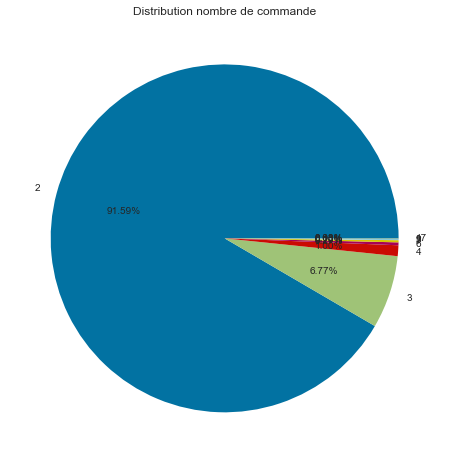

In [9]:
temp = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 1]
temp = temp[['customer_id','customer_unique_id']]
temp2 = dfs[5][dfs[5]['customer_id'].isin(temp['customer_id'])]
temp = temp.set_index('customer_id')
temp = temp.join(temp2[['customer_id','order_id']].set_index('customer_id'))
graph = pd.DataFrame()
graph['n_order'] = temp.groupby('customer_unique_id').order_id.count()

fig,ax = plt.subplots(figsize = (8,8))
ax.pie(graph['n_order'].value_counts(), labels = graph['n_order'].unique(),autopct='%1.2f%%' )
ax.set_title('Distribution nombre de commande')
fig.savefig('distrib_n_order2.png', bbox_inches = 'tight')

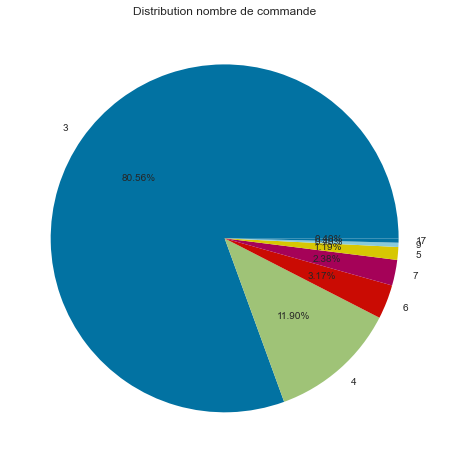

In [10]:
temp = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 2]
temp = temp[['customer_id','customer_unique_id']]
temp2 = dfs[5][dfs[5]['customer_id'].isin(temp['customer_id'])]
temp = temp.set_index('customer_id')
temp = temp.join(temp2[['customer_id','order_id']].set_index('customer_id'))
graph = pd.DataFrame()
graph['n_order'] = temp.groupby('customer_unique_id').order_id.count()

fig,ax = plt.subplots(figsize = (8,8))
ax.pie(graph['n_order'].value_counts(), labels = graph['n_order'].unique(),autopct='%1.2f%%' )
ax.set_title('Distribution nombre de commande')
fig.savefig('distrib_n_order3.png', bbox_inches = 'tight')

In [11]:
multi_cat_df['product_category_name'].unique().shape

(71,)

In [12]:
x = dfs[0]['customer_id'].unique().shape[0]
y = dfs[0]['customer_unique_id'].unique().shape[0]
print(x,y, 1-(y/x))

99441 96096 0.033638036624732304


In [13]:
import time
import datetime

def days(x):
    td = time.mktime(datetime.datetime.strptime('2018-10-18 00:00:00',"%Y-%m-%d %H:%M:%S").timetuple()) #date of last order
    t = time.mktime(datetime.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S").timetuple())
    d = int((td - t)/86400) #convert to day
    return d

In [14]:
def cat_name(x):
    y = set()
    for i in x:
        if i not in y: #check if the category is not already in the set
            y.add(i)
    y = str(y)
    return y

In [15]:
##build the working df of each order
#take the customer id
df = pd.DataFrame(multi_custom)
df = df.set_index('customer_id')
df = df.join(multi_order_df[['customer_id','order_id', 'order_purchase_timestamp']].set_index('customer_id'))
#take the value of each order
temp = pd.DataFrame()
temp['order_total'] = multi_pay_df.groupby('order_id').payment_value.sum() #some order have voucher
df = df.join(temp, on = 'order_id')
#calculate the days since order of each order
df['days_since_order'] = df['order_purchase_timestamp'].apply(days)
#take the review score for each order
temp = pd.DataFrame(index = multi_rev_df.index)
temp['review_days'] = multi_rev_df['review_creation_date'].apply(days)
temp = temp.join(multi_rev_df[['order_id', 'review_score']])
agg_fun = {'review_days' : ['min'], 'review_score' : ['mean']}
temp = temp.groupby('order_id').agg(agg_fun)
df = df.join(temp, on = 'order_id', how='right')
df = df.drop(df.columns[5], axis=1 ) 
df = df.rename(columns = {df.columns[5] : 'review_score'})

#take the product category of each order
temp = pd.DataFrame(multi_prod_df.groupby('order_id').product_category_name.agg(lambda x: tuple(x)))
temp['product_category_name'] = temp.applymap(cat_name) #some orders have mulitple items from the same category
df = df.join(temp, on = 'order_id')
df =df.dropna(subset = 'product_category_name')

df =  df[df.groupby('customer_unique_id').customer_unique_id.transform('count') > 1]#some customer didn't review all their orders
print(df.info(),df.head())
df.to_csv('df.csv', index = False)

C:\Users\Nico Janko\AppData\Local\Temp\ipykernel_9228\1912173821.py:18: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.join(temp, on = 'order_id', how='right')


<class 'pandas.core.frame.DataFrame'>
Index: 5929 entries, f6dd3ec061db4e3987629fe6b26e5cce to c5d108ecadaedf367e995520d36c9b1d
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        5929 non-null   object 
 1   order_id                  5929 non-null   object 
 2   order_purchase_timestamp  5929 non-null   object 
 3   order_total               5929 non-null   float64
 4   days_since_order          5929 non-null   int64  
 5   review_score              5929 non-null   float64
 6   product_category_name     5929 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 370.6+ KB
None                                                 customer_unique_id  \
customer_id                                                          
f6dd3ec061db4e3987629fe6b26e5cce  eb28e67c4c0b83846050ddfb8a35d051   
8085a9af46f619bc25966f151a362b0d  98758d88bf4b8eef1372ddee45d63178

In [16]:
#build the model df
md_df = pd.DataFrame(index = df['customer_unique_id'].unique())

#feature0  = number of order
md_df['n_order'] = df.groupby('customer_unique_id').order_id.count()

#feature1  = total value of orders
#md_df['payment_total'] = df.groupby('customer_unique_id').order_total.agg('sum')

#feature2-3  = mean and std of orders
md_df['payment_mean'] = df.groupby('customer_unique_id').order_total.agg('mean')
md_df['payment_std'] = df.groupby('customer_unique_id').order_total.agg('std')

#feature frequency4-10 of order on the distrib
df['order_dis'] = pd.cut(df['order_total'],50, duplicates = 'drop')
temp = pd.crosstab(df['customer_unique_id'], df['order_dis'], values = df['order_dis'], aggfunc= 'count', margins = True)
temp = temp.dropna(axis = 1, how = 'any') #drop empty buckets
for i in range(temp.shape[1]):
    temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)

temp = temp.drop(labels = 'All')
temp = temp.drop(labels = 'All', axis = 1)
md_df = md_df.join(temp)
print(md_df.info())
#feature frequency11-135 of category
temp = pd.crosstab(df['customer_unique_id'], df['product_category_name'], values = df['product_category_name'], aggfunc= 'count', margins = True).fillna(0)
for i in range(temp.shape[1]):
    temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)
temp = temp.drop(labels = 'All')
temp = temp.drop(labels = 'All', axis = 1)
md_df = md_df.join(temp)
print(md_df.info())
#feature136-137 review score mean and std
md_df['rev_mean'] = df.groupby('customer_unique_id').review_score.agg('mean')
md_df['rev_std'] = df.groupby('customer_unique_id').review_score.agg('std')
#feature138  = days since last order
md_df['days_since_last_order'] = df.groupby('customer_unique_id').days_since_order.agg('min')
#feature139 = "age" of the custumer
md_df['age'] = df.groupby('customer_unique_id').days_since_order.agg('max')


print(md_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2808 entries, eb28e67c4c0b83846050ddfb8a35d051 to acc4424c209233de519e034152f30304
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   n_order               2808 non-null   int64  
 1   payment_mean          2808 non-null   float64
 2   payment_std           2808 non-null   float64
 3   (6.621, 110.336]      2808 non-null   float64
 4   (110.336, 209.111]    2808 non-null   float64
 5   (209.111, 307.887]    2808 non-null   float64
 6   (307.887, 406.662]    2808 non-null   float64
 7   (406.662, 505.438]    2808 non-null   float64
 8   (505.438, 604.214]    2808 non-null   float64
 9   (604.214, 702.989]    2808 non-null   float64
 10  (702.989, 801.765]    2808 non-null   float64
 11  (801.765, 900.54]     2808 non-null   float64
 12  (900.54, 999.316]     2808 non-null   float64
 13  (999.316, 1098.092]   2808 non-null   float64
 14  (1098.092, 1196.86

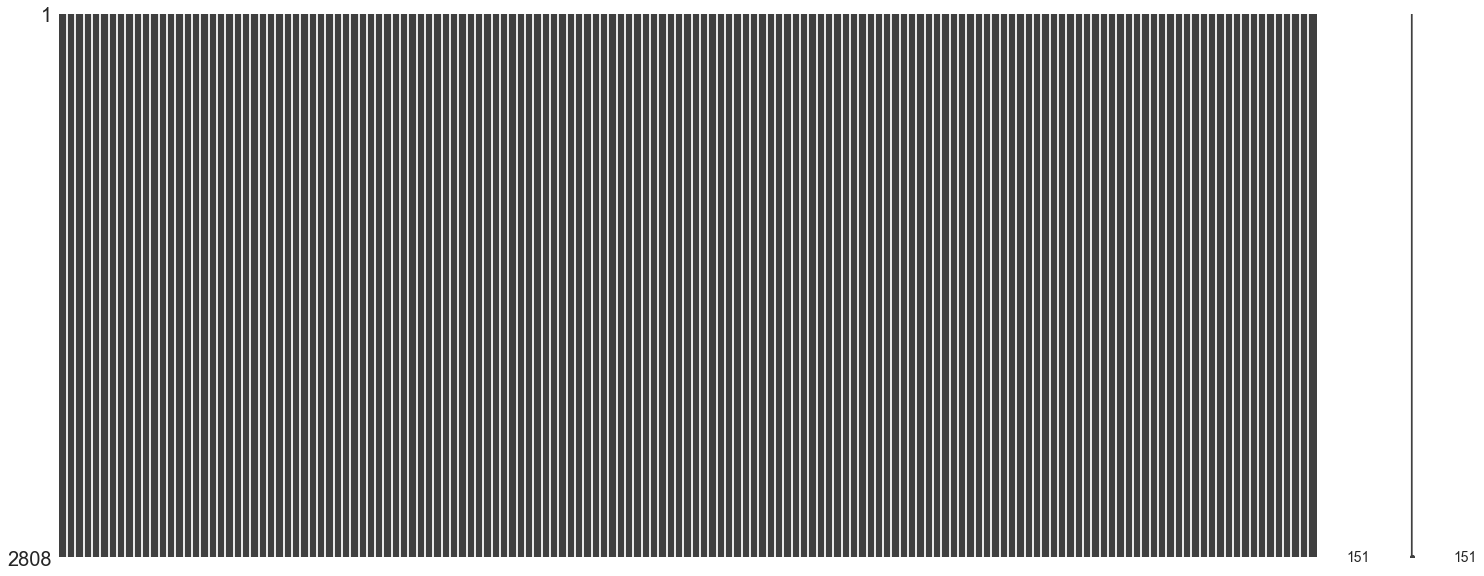

In [17]:
msno.matrix(md_df)
plt.savefig('msno_df_finale.png', bbox_inches = 'tight')

In [18]:
md_df.to_csv('md_df.csv', index = False)

## Dimention reduction

In [19]:
dim_df = pd.read_csv('md_df.csv')

x = dim_df.values
features = dim_df.columns

In [20]:
dim_df.isna().sum().sum()

0

In [21]:
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components = 2)
scaler = preprocessing.StandardScaler()
rscaler = preprocessing.RobustScaler()
mscaler = preprocessing.MinMaxScaler()

x_scale = rscaler.fit_transform(x)

pca.fit(x_scale)

PCA(n_components=2)

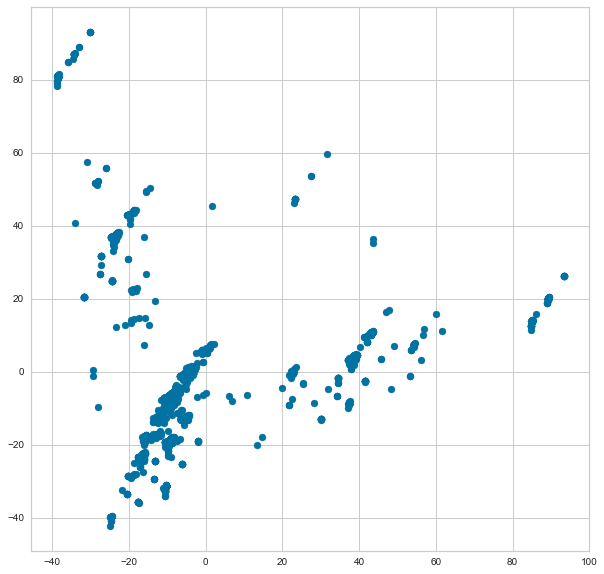

In [22]:
x_proj = pca.transform(x_scale)
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x_proj[:,0],x_proj[:,1])
plt.show()

In [23]:
from sklearn.manifold import Isomap
iso = Isomap()
from sklearn.manifold import MDS
mds = MDS()
from sklearn.manifold import TSNE
tsne = TSNE()

x_proj2 = mds.fit_transform(x_scale)
x_proj3 = tsne.fit_transform(x_scale)
x_proj4 = iso.fit_transform(x_scale)

C:\Users\Nico Janko\Documents\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Nico Janko\Documents\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Nico Janko\Documents\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Nico Janko\Documents\Data_Science\Anaconda\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Ni

In [24]:
from sklearn import cluster, metrics

Text(0.55, 0.4, 'Best silhouette : 0.33, Optimal Clus : 40')

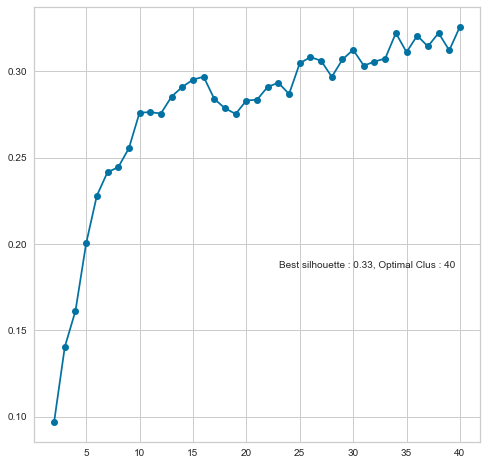

In [25]:
silhouette = []
for i in range(2,41):
    clus = cluster.KMeans(n_clusters = i, random_state = 38)
    clus.fit(x_scale)
    sil  = metrics.silhouette_score(x_scale, clus.labels_)
    silhouette.append(sil)
max_sil = max(silhouette)
index = (silhouette.index(max_sil) +2)
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(range(2,41), silhouette, marker ='o')
plt.savefig('cluster_optimizer.png', bbox_inches = 'tight')
ax.text(0.55,0.4,'Best silhouette : {:.2f}, Optimal Clus : {}'.format(max_sil, index), transform = ax.transAxes)

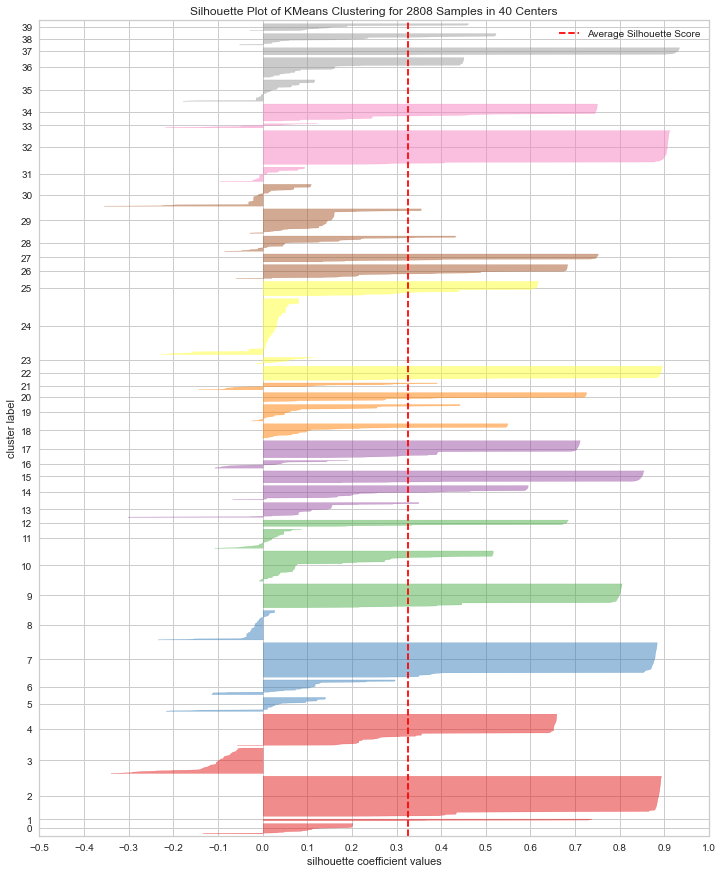

In [29]:
clus = cluster.KMeans(n_clusters = 40, random_state = 38)
clus.fit(x_scale)

fig, ax = plt.subplots(figsize = (12,15))
visualizer = SilhouetteVisualizer(clus, ax=ax)
visualizer.fit(x_scale)
visualizer.finalize()# Fit the data to the visualizer
plt.savefig('cluster_visualizer.png', bbox_inches = 'tight')
plt.show()   

In [46]:
tsne3d = TSNE(n_components=3)
x_proj3d = tsne3d.fit_transform(x_scale)



C:\Users\Nico Janko\Documents\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Nico Janko\Documents\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


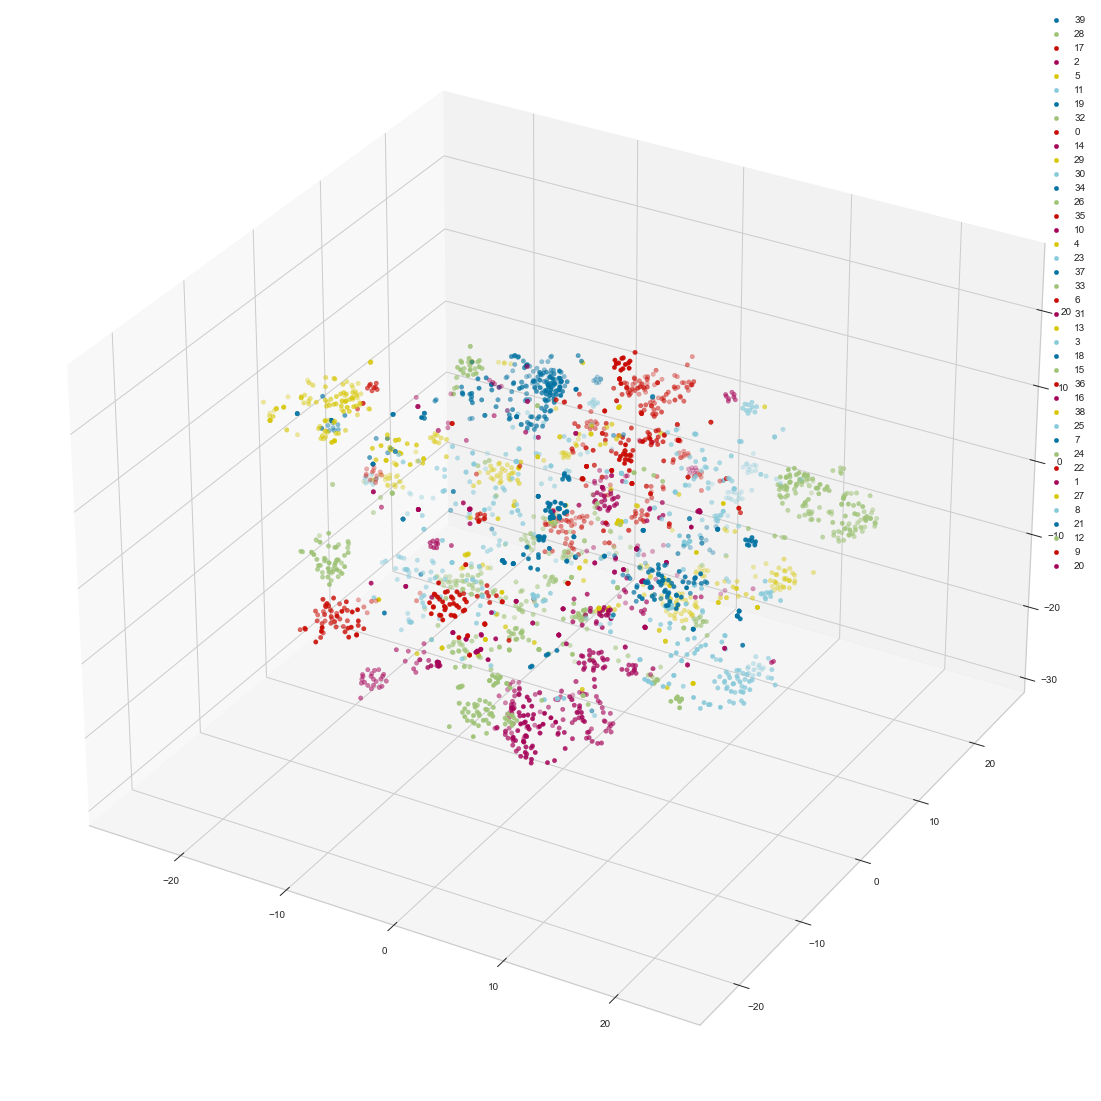

In [47]:
temp = pd.DataFrame(clus.labels_,columns =['label'])
temp = temp.join(pd.DataFrame(x_proj3d), lsuffix=index)
fig,ax =plt.subplots(subplot_kw={"projection": "3d"},figsize = (20,20))
for i in temp['label'].unique():   
    ax.scatter(temp[0].loc[temp['label'] == i],temp[1].loc[temp['label'] == i],temp[2].loc[temp['label'] == i], label = i)
plt.legend()
plt.savefig('cluster_3d.png', bbox_inches = 'tight')
plt.show()


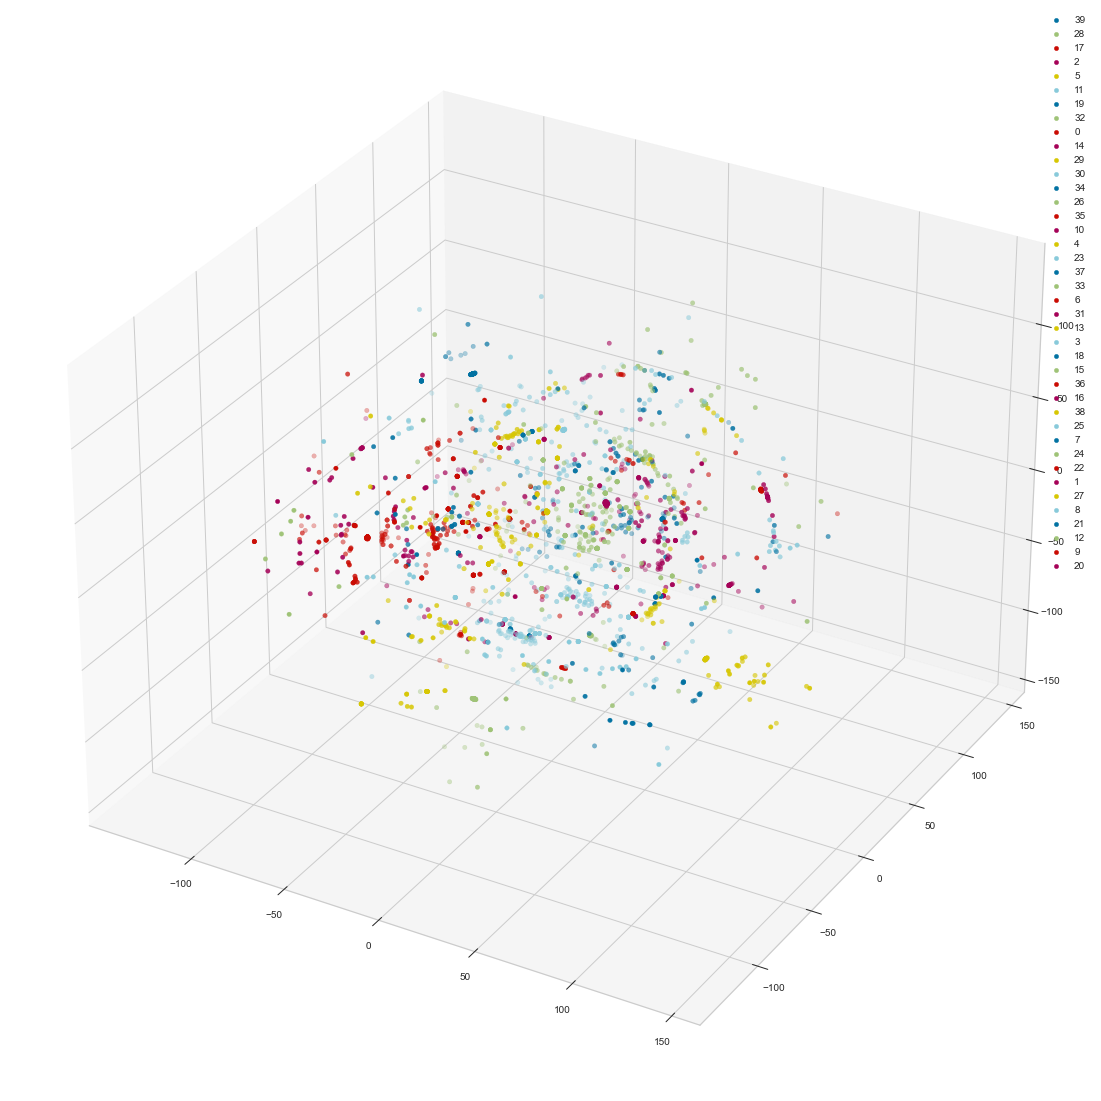

In [36]:
mds3d = MDS(n_components = 3)
x_proj3d = mds3d.fit_transform(x_scale)
temp = pd.DataFrame(clus.labels_,columns =['label'])
temp = temp.join(pd.DataFrame(x_proj3d), lsuffix=index)
fig,ax =plt.subplots(subplot_kw={"projection": "3d"},figsize = (20,20))
for i in temp['label'].unique():   
    ax.scatter(temp[0].loc[temp['label'] == i],temp[1].loc[temp['label'] == i],temp[2].loc[temp['label'] == i], label = i)
plt.legend()
plt.savefig('cluster_3d_mds.png', bbox_inches = 'tight')
plt.show()

C:\Users\Nico Janko\Documents\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Nico Janko\Documents\Data_Science\Anaconda\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Nico Janko\Documents\Data_Science\Anaconda\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Nico Janko\Documents\Data_Science\Anaconda\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expe

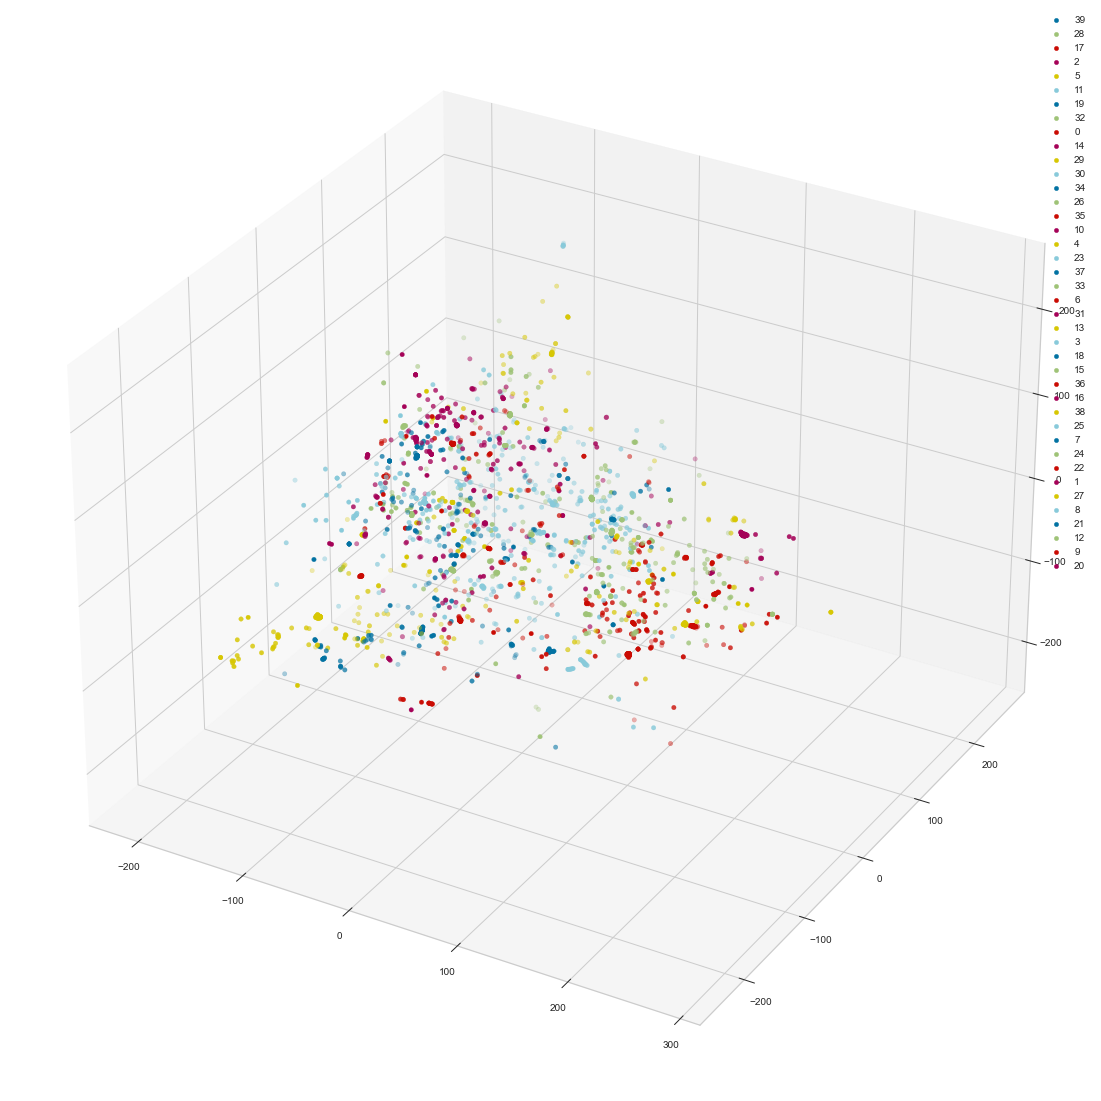

In [37]:
iso3d = Isomap(n_components = 3)
x_proj3d = iso3d.fit_transform(x_scale)
temp = pd.DataFrame(clus.labels_,columns =['label'])
temp = temp.join(pd.DataFrame(x_proj3d), lsuffix=index)
fig,ax =plt.subplots(subplot_kw={"projection": "3d"},figsize = (20,20))
for i in temp['label'].unique():   
    ax.scatter(temp[0].loc[temp['label'] == i],temp[1].loc[temp['label'] == i],temp[2].loc[temp['label'] == i], label = i)
plt.legend()
plt.savefig('cluster_3d_iso.png', bbox_inches = 'tight')
plt.show()

Text(0.55, 0.4, 'Best silhouette : 0.35, Optimal Eps : 4.0')

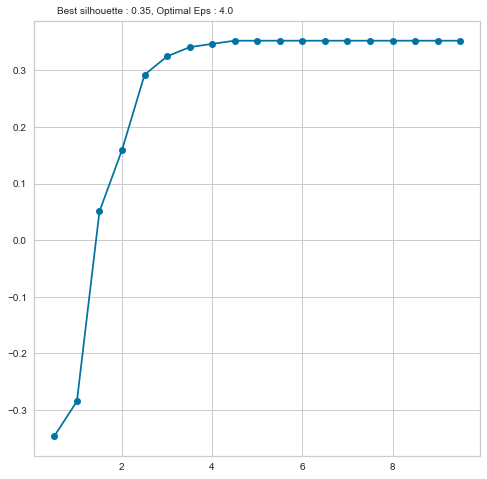

In [39]:
silhouette = []
eps_range = list(np.arange(0.5,10,0.5))
for i in eps_range:
    dbscan = cluster.DBSCAN(eps = i)
    dbscan.fit(x_scale)
    sil  = metrics.silhouette_score(x_scale, dbscan.labels_)
    silhouette.append(sil)
    
max_sil = max(silhouette)
index = (silhouette.index(max_sil))
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(np.arange(0.5,10,0.5), silhouette, marker ='o')
plt.savefig('dbscan_optimizer.png', bbox_inches = 'tight')
ax.text(0.55,0.4,'Best silhouette : {:.2f}, Optimal Eps : {}'.format(max_sil, round(index/2,2), transform = ax.transAxes))

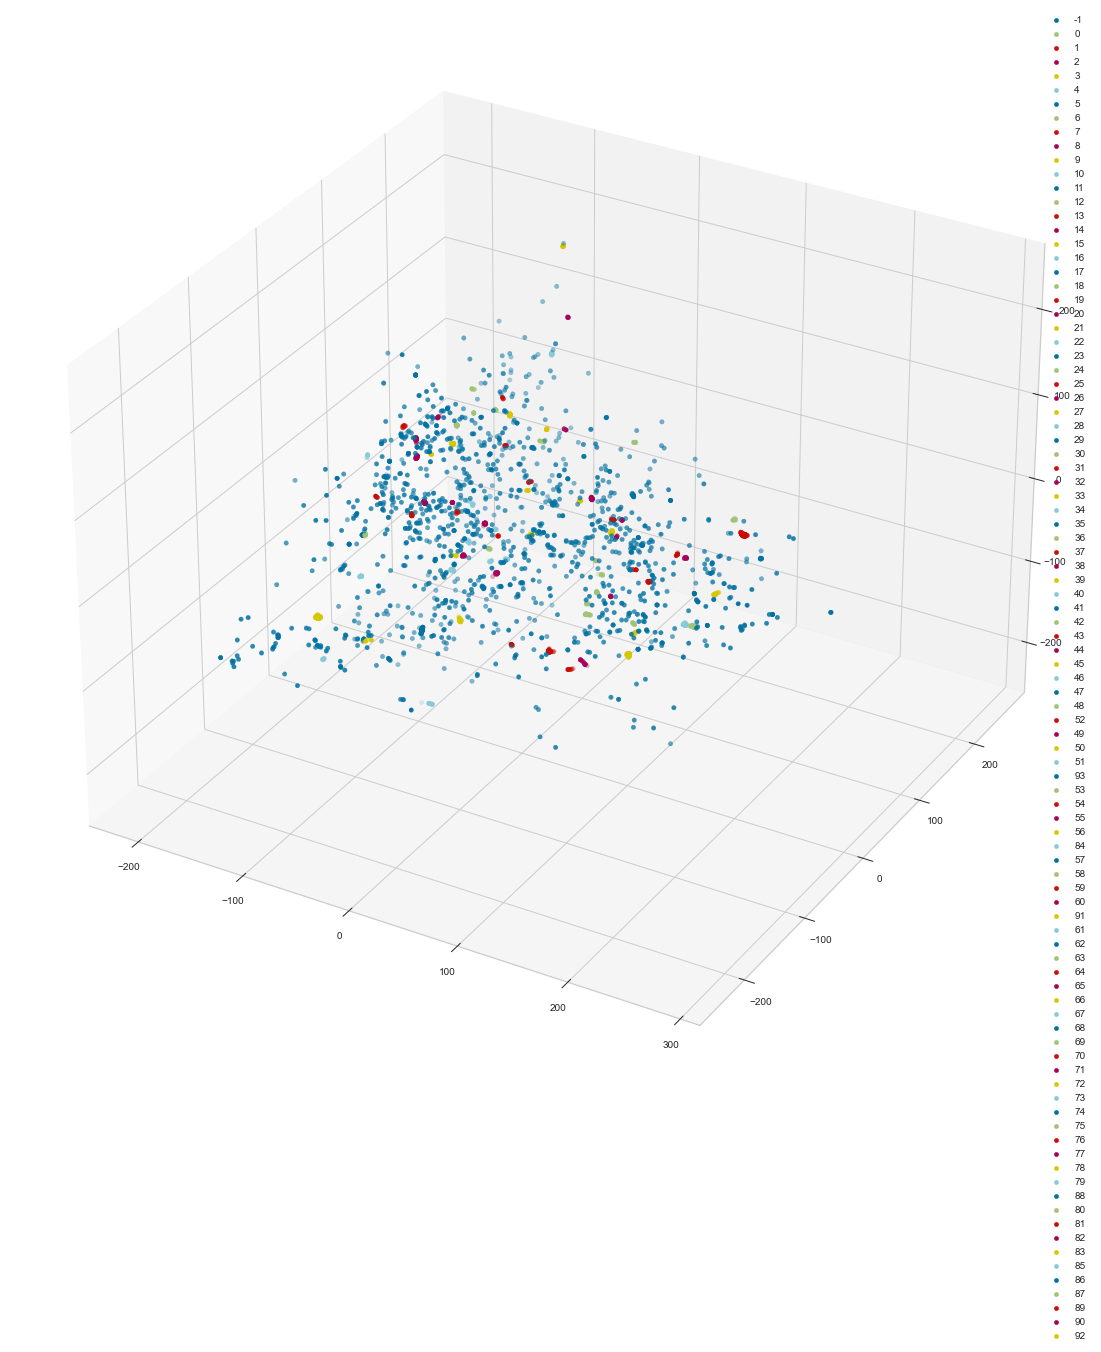

In [40]:
dbscan = cluster.DBSCAN(eps = 4.0)
dbscan.fit(x_scale)


temp = pd.DataFrame(dbscan.labels_,columns =['label'])
temp = temp.join(pd.DataFrame(x_proj3d), lsuffix=index)
fig,ax =plt.subplots(subplot_kw={"projection": "3d"},figsize = (20,20))
for i in temp['label'].unique():   
    ax.scatter(temp[0].loc[temp['label'] == i],temp[1].loc[temp['label'] == i],temp[2].loc[temp['label'] == i], label = i)
plt.legend()
plt.savefig('dbscan_cluster_3d.png', bbox_inches = 'tight')
plt.show()

In [41]:
md_df['clus_label'] = clus.labels_
clus_sil = round(metrics.silhouette_score(x_scale, clus.labels_),2)
md_df['dbscan_label'] = dbscan.labels_
dbscan_sil = round(metrics.silhouette_score(x_scale, dbscan.labels_),2)
print('KMeans have found {} clusters with a silhouette score of : {}'.format(len(md_df['clus_label'].unique()), clus_sil))
print('BDscan have found {} clusters with a silhouette score of : {}'.format(len(md_df['dbscan_label'].unique()), dbscan_sil))

KMeans have found 40 clusters with a silhouette score of : 0.33
BDscan have found 95 clusters with a silhouette score of : 0.35


In [42]:
md_df.describe()

,n_order,payment_mean,payment_std,"(6.621, 110.336]","(110.336, 209.111]","(209.111, 307.887]","(307.887, 406.662]","(406.662, 505.438]","(505.438, 604.214]","(604.214, 702.989]",...,{'tablets_impressao_imagem'},{'telefonia'},{'telefonia_fixa'},{'utilidades_domesticas'},rev_mean,rev_std,days_since_last_order,age,clus_label,dbscan_label
count,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,...,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000
mean,2.111467,147.191666,65.919883,55.025734,27.005345,9.471300,3.699345,1.746189,0.795335,0.534188,...,0.053419,3.092347,0.189932,5.467325,4.161333,0.493856,269.561254,357.469729,18.209402,15.272436
std,0.494397,152.453940,112.698087,40.074716,33.885965,22.453404,14.417198,9.503202,6.520163,5.637131,...,1.507701,14.653463,3.044006,18.047675,1.104741,0.819745,144.534403,146.738439,11.490999,24.154034
min,2.000000,15.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,44.000000,54.000000,0.000000,-1.000000
25%,2.000000,71.478750,8.987327,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.500000,0.000000,153.750000,241.000000,8.000000,-1.000000
50%,2.000000,110.155000,32.682475,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.500000,0.000000,248.500000,352.500000,18.000000,1.000000
75%,2.000000,172.345000,76.314499,100.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,0.707107,369.000000,475.000000,29.000000,24.000000
max,15.000000,3785.815000,1646.887049,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,50.000000,100.000000,50.000000,100.000000,5.000000,2.828427,740.000000,744.000000,39.000000,93.000000


In [43]:
n_order_m = md_df.describe().iloc[1,0]
payment_m = md_df.describe().iloc[1,1]
rev_m_m = md_df.describe().iloc[1,-6]
age_m = md_df.describe().iloc[1,-3]

In [44]:
#build the explanatory df
expl_df = pd.DataFrame()
#first the frequence of the clusters
expl_df['freq'] = md_df.groupby('clus_label').n_order.count()
expl_df['freq'] = round((expl_df['freq']/md_df.shape[0])*100,2)
#the mean ,ratio and max of the number of order
expl_df['n_order_mean'] = md_df.groupby('clus_label').n_order.agg('mean')
expl_df['n_order_ratio'] = round(expl_df['n_order_mean']/n_order_m,2)
expl_df['n_order_max'] = md_df.groupby('clus_label').n_order.agg('max')
#the mean and the ratio of the mean of payment
expl_df['payment_m_m'] = md_df.groupby('clus_label').payment_mean.agg('mean')
expl_df['payment_m_r'] = round(expl_df['payment_m_m']/payment_m,2)
#the mean and ratio of the mean of review score
expl_df['rev_m_m'] = md_df.groupby('clus_label').rev_mean.agg('mean')
expl_df['rev_ratio'] =round(expl_df['rev_m_m']/rev_m_m,2)
#the mean and ratio of the age of each cluster
expl_df['age_m_m'] = md_df.groupby('clus_label').age.agg('mean')
expl_df['age_ratio'] =round(expl_df['age_m_m']/age_m,2)
#the top2 payment bucket for each cluster
temp = pd.DataFrame(md_df.groupby('clus_label').mean())
temp = temp.iloc[:,3:18]
temp2 = temp.T

top1=[]
top2=[]
for i in range(temp2.shape[1]):    
    val = list(round(temp2.iloc[:,i].nlargest(2),2))
    cat = list(temp2.iloc[:,i].nlargest(2).index)
    cat_top2 = dict(zip(cat, val))
    cat_list = []
    for y in cat_top2:
        cat_list.append(str(y)+' : '+str(cat_top2[y]))
    top1.append(cat_list[0])
    top2.append(cat_list[1])
   
       
expl_df = expl_df.join(pd.DataFrame({'top1_pay' : top1, 'top2_pay' : top2}))
#the top2 categories for each cluster
temp = pd.DataFrame(md_df.groupby('clus_label').mean())
temp = temp.iloc[:,24:-5]
temp2 = temp.T

top1=[]
top2=[]
for i in range(temp2.shape[1]):    
    val = list(round(temp2.iloc[:,i].nlargest(2),2))
    cat = list(temp2.iloc[:,i].nlargest(2).index)
    cat_top2 = dict(zip(cat, val))
    cat_list = []
    for y in cat_top2:
        cat_list.append(str(y)+':'+str(cat_top2[y]))
    top1.append(cat_list[0])
    top2.append(cat_list[1])
   
       
expl_df = expl_df.join(pd.DataFrame({'top1_cat' : top1, 'top2_cat' : top2}))

expl_df

,freq,n_order_mean,n_order_ratio,n_order_max,payment_m_m,payment_m_r,rev_m_m,rev_ratio,age_m_m,age_ratio,top1_pay,top2_pay,top1_cat,top2_cat
clus_label,,,,,,,,,,,,,,
0,1.46,2.195122,1.04,5,135.477236,0.92,4.225203,1.02,355.365854,0.99,"(6.621, 110.336] : 50.65","(209.111, 307.887] : 33.01",{'beleza_saude'}:50.89,{'esporte_lazer'}:22.03
1,0.28,2.500000,1.18,4,91.208542,0.62,4.218750,1.01,360.500000,1.01,"(6.621, 110.336] : 68.75","(110.336, 209.111] : 23.96",{'esporte_lazer'}:50.0,{'telefonia'}:42.71
2,5.66,2.100629,0.99,7,115.273119,0.78,3.917191,0.94,366.018868,1.02,"(6.621, 110.336] : 65.77","(110.336, 209.111] : 27.96",{'cama_mesa_banho'}:100.0,{'agro_industria_e_comercio'}:0.0
3,3.60,2.326733,1.10,6,205.015871,1.39,4.409076,1.06,325.930693,0.91,"(6.621, 110.336] : 51.6","(110.336, 209.111] : 32.36",{'bebidas'}:6.02,{'livros_interesse_geral'}:5.94
4,4.42,2.080645,0.99,4,170.629147,1.16,3.985215,0.96,324.120968,0.91,"(6.621, 110.336] : 56.32","(110.336, 209.111] : 28.36",{'informatica_acessorios'}:90.86,{'malas_acessorios'}:1.21
5,1.99,2.178571,1.03,3,140.304792,0.95,4.186012,1.01,365.821429,1.02,"(6.621, 110.336] : 56.85","(110.336, 209.111] : 36.31",{'beleza_saude'}:50.6,{'informatica_acessorios'}:7.74
6,2.10,2.033898,0.96,3,215.788249,1.47,3.990113,0.96,380.949153,1.07,"(209.111, 307.887] : 61.3","(110.336, 209.111] : 17.8",{'moveis_decoracao'}:62.43,{'beleza_saude'}:4.24
7,4.88,2.051095,0.97,4,114.738418,0.78,4.240268,1.02,348.124088,0.97,"(6.621, 110.336] : 65.88","(110.336, 209.111] : 27.74",{'beleza_saude'}:99.64,"{'beleza_saude', 'malas_acessorios'}:0.18"
8,4.17,2.102564,1.00,4,169.121681,1.15,4.375356,1.05,359.094017,1.00,"(6.621, 110.336] : 56.77","(110.336, 209.111] : 25.07",{'utilidades_domesticas'}:49.86,{'esporte_lazer'}:4.34


#### 